In [6]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

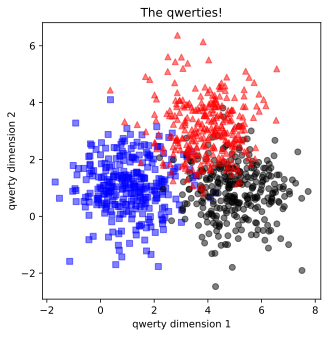

In [7]:
nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [8]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [9]:
def createTheQwertyNet(optimizerAlgo,lr):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr( torch.optim,optimizerAlgo )
  optimizer = optifun(net.parameters(),lr=lr)

  return net,lossfun,optimizer


In [10]:
def function2trainTheModel(optimizerType,lr,numepochs):

  # number of epochs
  
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(optimizerType,lr)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [11]:
start = -4  # 10^-3
end = -1    # 10^-1
num_rates = 20

learning_rates = np.logspace(start, end, num_rates)
print(learning_rates)


[0.0001     0.00014384 0.00020691 0.00029764 0.00042813 0.00061585
 0.00088587 0.00127427 0.00183298 0.00263665 0.00379269 0.00545559
 0.0078476  0.01128838 0.01623777 0.02335721 0.03359818 0.0483293
 0.06951928 0.1       ]


In [13]:

results = np.zeros((20,3))

for li,lr in enumerate(learning_rates):
    for opi,opto in enumerate(['SGD','RMSprop','Adam']):
        trainAcc,testAcc,losses,net = function2trainTheModel(opto,lr,20)

  # store the final results
        train = np.mean(trainAcc[-10:])
        test  = np.mean(testAcc[-10:])

        results[li,opi] = test


print(results) 

[[ 4.66666698 47.55555344 63.        ]
 [36.66666412 86.77778625 55.55556107]
 [27.77777672 65.11110687 88.77778625]
 [40.55555344 64.33333588 65.77778625]
 [86.         80.66666412 87.1111145 ]
 [65.11112213 88.00000763 93.        ]
 [34.66666794 90.22221375 81.66666412]
 [55.         89.11112213 89.1111145 ]
 [75.33333588 90.11110687 91.1111145 ]
 [61.88889313 90.         90.77777863]
 [71.77777863 89.88889313 90.777771  ]
 [80.         90.44444275 91.77777863]
 [55.88889313 90.77778625 90.        ]
 [82.33332825 90.44444275 90.44444275]
 [89.77777863 90.66667175 90.33332825]
 [89.66666412 89.88889313 91.00000763]
 [89.66667175 90.11112213 89.        ]
 [90.77778625 89.66667175 90.66667175]
 [90.88889313 89.         89.44444275]
 [89.66666412 86.77777863 87.55555725]]


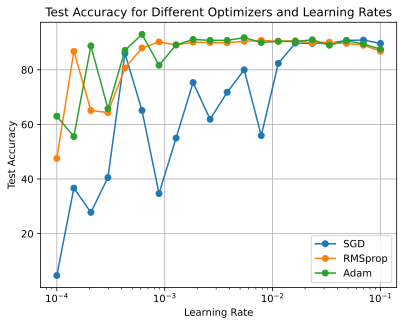

In [14]:
# Assuming 'results' is your 2D NumPy array from the previous code
# And 'learning_rates' is the array of learning rates

optimizers = ['SGD', 'RMSprop', 'Adam']

# Plotting
for i, opto in enumerate(optimizers):
    plt.plot(learning_rates, results[:, i], marker='o', label=opto)

plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy for Different Optimizers and Learning Rates')
plt.xscale('log')  # Since your learning rates are on a log scale
plt.legend()
plt.grid(True)
plt.show()
